In [1]:
from __future__ import print_function

import subprocess
import seaborn as sns
import pandas as pd
import DyMat

from matplotlib import pyplot as plt

from ipywidgets import interact, interactive, fixed, interact_manual, FloatSlider
import ipywidgets as widgets

import numpy as np
import math
from tqdm import tqdm
import os

from scipy import fftpack

import tempfile

In [2]:
sampling_rate = 50 # Hz
simulation_time = 30

In [3]:
%cd seesaw3_build/

/home/lukas/Projects/TrussFab/src/system_simulation/seesaw3_build


In [13]:
overrides = "startTime=0,stopTime={},stepSize={},outputFormat=mat,variableFilter=revLeft.*".format(simulation_time, 1/sampling_rate)

In [12]:
time subprocess.call(["./seesaw3", "-override springDamperParallel1.c='10"])

CPU times: user 3.66 ms, sys: 20.5 ms, total: 24.2 ms
Wall time: 118 ms


0

In [14]:
subprocess.run("./seesaw3 -outputPath={} -override={} -cpu".format('.', overrides, 100), shell=True, capture_output=True)

CompletedProcess(args='./seesaw3 -outputPath=. -override=startTime=0,stopTime=30,stepSize=0.02,outputFormat=mat,variableFilter=revLeft.* -cpu', returncode=0, stdout=b'LOG_SUCCESS       | info    | The initialization finished successfully without homotopy method.\nLOG_SUCCESS       | info    | The simulation finished successfully.\n', stderr=b'')

In [15]:
subprocess.run("./seesaw3 -outputPath={} -override={} -cpu".format('.', overrides, 100), shell=True, capture_output=True)

CompletedProcess(args='./seesaw3 -outputPath=. -override=startTime=0,stopTime=30,stepSize=0.02,outputFormat=mat,variableFilter=revLeft.* -cpu', returncode=0, stdout=b'LOG_SUCCESS       | info    | The initialization finished successfully without homotopy method.\nLOG_SUCCESS       | info    | The simulation finished successfully.\n', stderr=b'')

In [16]:
def getFreq(c=100):
    with tempfile.TemporaryDirectory(dir='.') as tempdir:
        subprocess.run("./seesaw3 -outputPath={} -override {},springDamperParallel1.c='{}'".format(tempdir, overrides, c), check=True, shell=True)
        d = DyMat.DyMatFile(tempdir + '/seesaw3_res.mat')
    return d['revLeft.phi']

def getFreqPlot(c=100):
    return pd.DataFrame(getFreq(c)).plot(title="C={}".format(c))

In [17]:
def range_metric(array: np.array):
    return array.ptp()

def puke_metric(array):
    return np.absolute(np.gradient(array)).sum()

def eigenmodes_metric(x):
    return fftpack.fftfreq(len(x)) * sampling_rate

In [10]:
puke_metric([-1000,10,10,20, 100, -1000])

3175.0

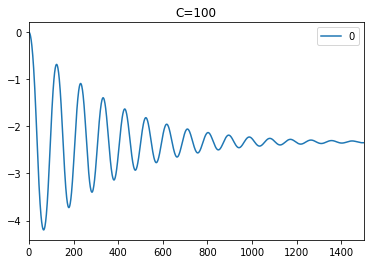

In [18]:
getFreqPlot(100)

In [19]:
def plot_eigenmodes(c=100):
    test = data[c]
    
    fig, ax = plt.subplots()
    X = fftpack.fft(test)
    
    ax.stem(eigenmodes_metric(test), np.abs(X))
    ax.set_xlabel('Frequency in Hertz [Hz]')
    ax.set_ylabel('Frequency Domain (Spectrum) Magnitude')
    ax.set_ylim(0, 300)
    ax.set_xlim(.1, 2)

In [20]:
time getFreq(10)

CPU times: user 28.7 ms, sys: 27 ms, total: 55.7 ms
Wall time: 288 ms


array([ 0.00000000e+00, -1.66919979e-03, -6.66934132e-03, ...,
       -2.32312527e+00, -2.32384122e+00, -2.32384122e+00])

In [21]:
interact(getFreqPlot, c=(0,20000,100))

interactive(children=(IntSlider(value=100, description='c', max=20000, step=100), Output()), _dom_classes=('wi…

<function __main__.getFreqPlot(c=100)>

In [25]:
interact(plot_eigenmodes, data=(0,100,1), i=FloatSlider(min=1e5, max=1e7, step=1e5))

interactive(children=(IntSlider(value=100, description='c', max=300, min=-100), Output()), _dom_classes=('widg…

<function __main__.plot_eigenmodes(c=100)>

In [ ]:
time getFreq(100)

In [ ]:
ranges = []

for c in tqdm(range(0, 20000, 100)):
    ranges.append(range_metric(getFreq(c)))
    
pd.DataFrame(ranges).plot()

In [23]:
import time
import concurrent.futures

e = concurrent.futures.ThreadPoolExecutor(4)
s = range(0, 20000, 100)
# calc = lambda c: range_metric(getFreq(c))

data = [x for x in tqdm(e.map(getFreq, s))]

200it [00:10, 19.06it/s]


In [27]:
puke_index_res = [puke_metric(ts) for ts in data]

In [26]:
s[25]

2500

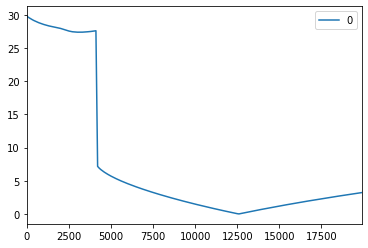

In [28]:
pd.DataFrame(puke_index_res, index=s).plot()